In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# for requirements: install fastparquet 

import glob # not needed in requirements
import os # not needed in requirements

In [3]:
PATH_TOPO = '..\\..\\Data_Handover\\TOPO\\Lyon\\part-00000-2f038a97-7faf-46f3-aee2-b73b52bf2cba.snappy.parquet'

In [4]:
enb_df = pd.read_parquet(PATH_TOPO, engine='fastparquet')
enb_df

,LocInfo,TECHNO,LON,LAT
0,8102f8100000ba1a,4G,4.805831,45.881115
1,8102f8100000ae6f,4G,5.103326,45.661649
2,8102f8100000b9fc,4G,5.006670,45.770836
3,8102f8100000999d,4G,4.888138,45.738378
4,8102f81000009baf,4G,4.889202,45.744970
...,...,...,...,...
9324,0102f810041ec940,3G,4.695403,45.642543
9325,0002f8100705368e,2G,4.849999,45.753893
9326,0002f810511084f7,2G,4.768475,45.784375
9327,0102f810041e6337,3G,4.865802,45.673625


In [39]:
np.arange(16, 23, 1)

array([16, 17, 18, 19, 20, 21, 22])

In [9]:
PATH_HO = '..\\..\\Data_Handover\\usersHandovers\\2019\\03\\16\\Lyon_HO_IN'

all_files = glob.glob(PATH_HO + "\\*.parquet")

li = []

for filename in all_files:
    df = pd.read_parquet(filename, engine='fastparquet')
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame

,timeSlot,srcLocInfo,dstLocInfo,nbHO15
0,1552734000,8102f81000009986,8102f81000009991,171
1,1552753800,8102f810000099d1,8102f810000099ae,1508
2,1552757400,8102f8100000a481,8102f81000009c31,814
3,1552753800,8102f81000009de8,8102f81000009d5e,277
4,1552732200,8102f81000009952,8102f81000009975,1198
...,...,...,...,...
719641,1552759200,0002f8100704edda,0002f8100704512d,0
719642,1552759200,0002f81051100807,0002f81051053587,0
719643,1552746600,8102f8100000ba74,8102f8100000ba60,0
719644,1552770000,8102f810000099c9,8102f8100000babc,0


In [11]:
frame.columns

Index(['timeSlot', 'srcLocInfo', 'dstLocInfo', 'nbHO15'], dtype='object')

In [34]:
agg = frame.groupby(['srcLocInfo', 'dstLocInfo'])['nbHO15'].sum()
df_agg = pd.DataFrame(agg)
df_agg = df_agg[df_agg['nbHO15'] >0] 
#agg = agg.drop(agg.loc[agg.values==0].index)
#agg

In [35]:
df_agg.to_parquet(path='HO_AGG.snappy.parquet', engine='fastparquet', compression='snappy')

In [36]:
pd.read_parquet(path='HO_AGG.snappy.parquet', engine='fastparquet')

nbHO15
srcLocInfo       dstLocInfo              
0002f81000686160 0002f81007013bfa      26
0002f810041c2388 0002f81007041283      16
0002f81007011463 0002f8100701fe3f      31
0002f81007011465 0002f810070126d7      17
0002f810070114de 0002f81007013336    1240
...                                   ...
8102f8100000bad0 8102f8100000a1fa     515
                 8102f8100000a4d9      57
                 8102f8100000b9cc    5924
                 8102f8100000ba30     189
                 8102f8100000babe     184

[11700 rows x 1 columns]

(array([4.5424e+04, 8.7300e+02, 3.4500e+02, 2.2400e+02, 1.3600e+02,
        6.6000e+01, 4.0000e+01, 3.6000e+01, 2.0000e+01, 1.1000e+01,
        8.0000e+00, 4.0000e+00, 3.0000e+00, 4.0000e+00, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([     0.  ,   4723.98,   9447.96,  14171.94,  18895.92,  23619.9 ,
         28343.88,  33067.86,  37791.84,  42515.82,  47239.8 ,  51963.78,
         56687.76,  61411.74,  66135.72,  70859.7 ,  75583.68,  80307.66,
         85031.64,  89755.62,  94479.6 ,  99203.58, 103927.56, 108651.54,
        113375.52, 118

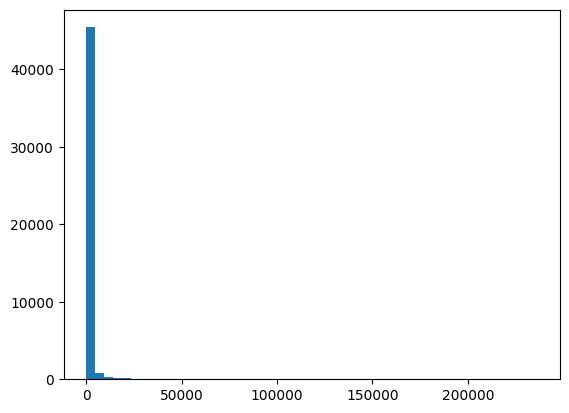

In [27]:
plt.hist(agg, bins=50)

In [6]:
src = '8102f81000009986'

enb_df[enb_df['LocInfo']==src] 

,LocInfo,TECHNO,LON,LAT
106,8102f81000009986,4G,4.876117,45.730001
